<a href="https://colab.research.google.com/github/SvetLanchY/CompLing/blob/main/%D0%92%D0%95%D0%9A%D0%A2%D0%9E%D0%A0%D0%98%D0%97%D0%90%D0%A6%D0%98%D0%AF_%D0%A2%D0%95%D0%9A%D0%A1%D0%A2%D0%9E%D0%92_%D0%B0%D0%B2%D1%82%D0%BE%D0%B1%D1%80%D0%B5%D1%8F_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Снижение размерности
* LSI
* PCA
* t-SNE
* UMAP

##### импорты и вспомогательный код

In [1]:
!pip install umap-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.pipeline import *
from sklearn.metrics import *
from sklearn.cluster import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE, MDS
import re
import umap
import gensim
import seaborn as sns

In [21]:
%matplotlib inline

style.use('ggplot')

def draw_subplots(data, colors, plotname, n_clusters, plot_centers=False, 
                  cmap='viridis', header='Clustering example'):
    plot = plotname
    
    # рисуем нули
    plot.axhline(0, color='#afafaf')
    plot.axvline(0, color='#afafaf')
    
    # рисуем точки
    for i in range(n_clusters):
        try:
            sc = plot.scatter(data[i:,0], data[i:,1], s=30, c=colors, cmap=cmap)
        except (KeyError, ValueError) as e: # костыль для бага матплотлиба
            pass
  
    
    # рисуем центроиды
    if plot_centers == True:
        plot.scatter(centers[:,0], centers[:,1], marker="x", c='r')
    
    # подписи осей
    plot.set_xlabel('Principal Component 1')
    plot.set_ylabel('Principal Component 2')
    
    size=81
    
    lp = lambda i: plt.plot([],color=sc.cmap(sc.norm(i)), ms=np.sqrt(size), mec="none",
                            label=i, ls="", marker="o")[0]
    handles = [lp(i) for i in np.unique(colors)]
    plot.legend(handles=handles)

    # заголовок
    plot.set_title(header)

## Возьмём какие-то данные и поснижаем у них размерность
Давайте возьмём для примера датасет новостей из sklearn. Снижение размерности будем рассматривать на его Tf-Idf представлении. 

In [22]:
cats = ['talk.religion.misc', 'sci.space', 'talk.politics.mideast', 'comp.graphics']

dataset = fetch_20newsgroups(subset='all', shuffle=True, random_state=42, categories=cats)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

data = dataset.data
labels = dataset.target

3528 documents
4 categories


In [8]:
dataset.target_names

['comp.graphics', 'sci.space', 'talk.politics.mideast', 'talk.religion.misc']

In [7]:
dataset.data[0], dataset.target_names[dataset.target[0]]

('From: cza@troy.cc.bellcore.com (C. Akgun)\nSubject: Re: Turkey-Cyprus-Bosnia-Serbia-Greece (Armenia-Azeris)\nNntp-Posting-Host: troy.cc.bellcore.com\nOrganization: BCR, NJ-USA\nLines: 126\n\nIn article <C5I6rK.L9I@news.cso.uiuc.edu> msg7038@uxa.cso.uiuc.edu (Michalis  Syrimis) writes:\n[...}\n>>any concentration/labor camp in Turkey (around 1974 or\n>>later) for Cypriot Greeks (or any Greeks) rather than talking\n>>nonsense like above, I will be glad to read what they got.\n>\n>How can you be in a position to know about any kind of concentration camps\n>Akgun?\n\nLiving through those days at the age of 20 and following\nthe internal and external news gives me that knowledge\nand position.  In 1974, Turkey had a democratic goverment and free\npress at that time.  Forget about internal news agencies, I haven\'t\nheard anything from any international source about any\nconcentration camps with Greek Cypriot prisoners in Turkey.\nHowever, I heard Adana POW camp.  It was not secret and wel

In [34]:
vectorize_machine = TfidfVectorizer(max_df=0.9, min_df=5, ngram_range=(1,3), analyzer='word', stop_words ='english')
tfidf_vectors = vectorize_machine.fit_transform(data)
tfidf_vectors.shape

(3528, 37147)

In [36]:
vectorize_machine.get_feature_names()[10000]

'deplorable'

In [31]:
import pandas
pandas.DataFrame.sparse.from_spmatrix(tfidf_vectors)

NameError: ignored

### Учим снижение размерности для данных

#### LSI


In [18]:
labels

array([2, 3, 1, ..., 1, 2, 3])

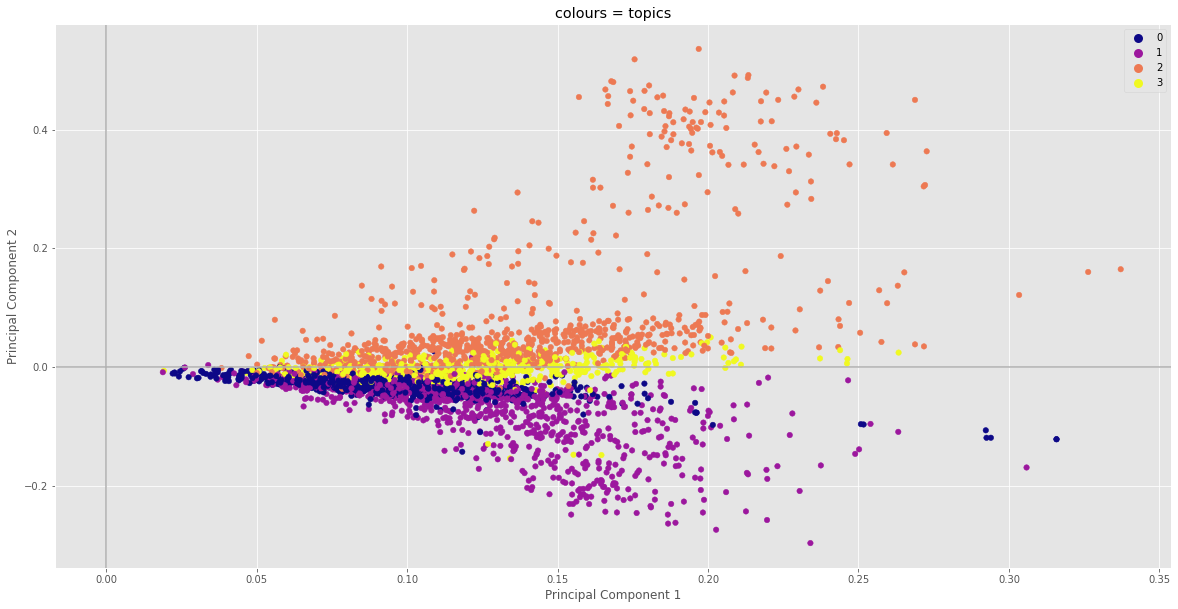

In [25]:
svd = TruncatedSVD(n_components=2)
X_2D_SVD = svd.fit_transform(X.todense())


# рисуем сабплоты
fig, plot1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 10))


# цвета = темы
draw_subplots(X_2D_SVD, labels, plot1, n_clusters=1, header='colours = topics', cmap='plasma', plot_centers=False)

#### PCA

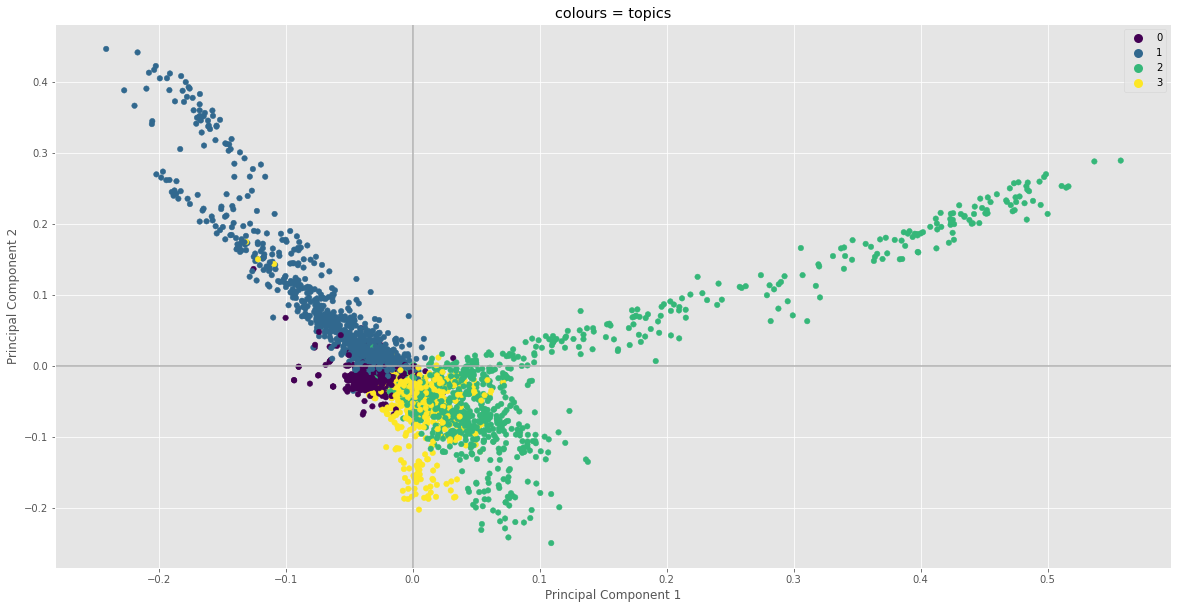

In [27]:
pca = PCA(n_components=2)
X_2D_PCA = pca.fit_transform(X.todense())

# рисуем сабплоты
fig, plot1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 10))


# цвета = темы
draw_subplots(X_2D_PCA, labels, plot1, n_clusters=1, header='colours = topics')

#### t-SNE

In [ ]:
%time X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X.todense())

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

##### Хаки с t-SNE
Можно предснизить размерность e.g. PCA, а потом применять t-SNE. Говорят, иногда работает лучше.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3528 samples in 0.020s...
[t-SNE] Computed neighbors for 3528 samples in 1.432s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3528
[t-SNE] Computed conditional probabilities for sample 2000 / 3528
[t-SNE] Computed conditional probabilities for sample 3000 / 3528
[t-SNE] Computed conditional probabilities for sample 3528 / 3528
[t-SNE] Mean sigma: 0.082493
[t-SNE] Computed conditional probabilities in 0.313s
[t-SNE] Iteration 50: error = 79.8743668, gradient norm = 0.0272284 (50 iterations in 2.369s)
[t-SNE] Iteration 100: error = 75.7969818, gradient norm = 0.0051271 (50 iterations in 1.660s)
[t-SNE] Iteration 150: error = 75.6440887, gradient norm = 0.0029952 (50 iterations in 1.637s)
[t-SNE] Iteration 200: error = 75.6190033, gradient norm = 0.0005793 (50 iterations in 1.676s)
[t-SNE] Iteration 250: error = 75.6149902, gradient norm = 0.0005956 (50 iterations in 1.729s)
[t-SNE] KL divergence after 250 iterat

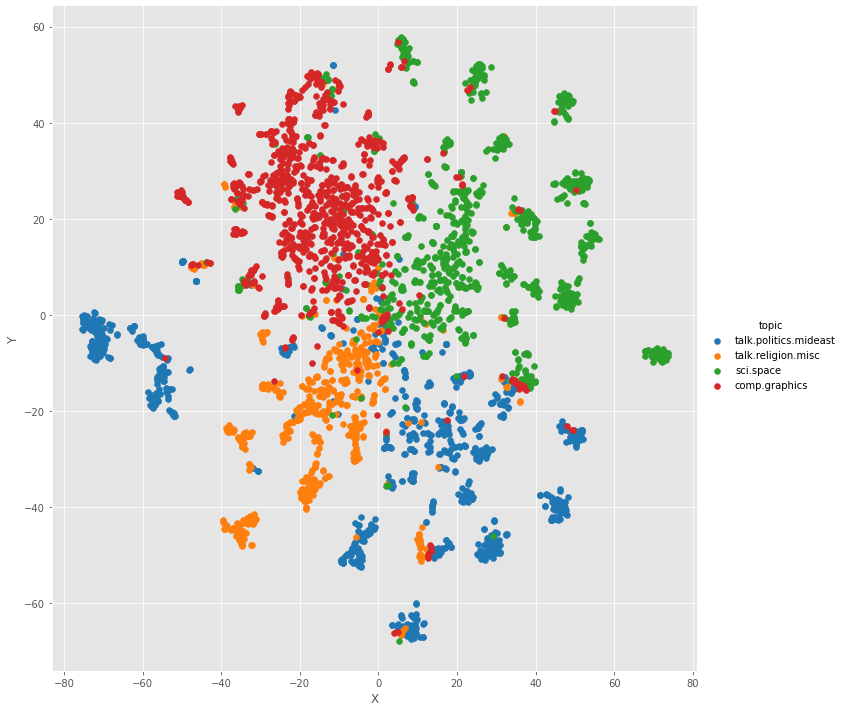

In [32]:
svd50 = TruncatedSVD(n_components=50)
X_50_SVD = svd50.fit_transform(X.todense())
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_50_SVD)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

In [ ]:
pca30 = PCA(n_components=30)
X_30_PCA = pca30.fit_transform(X.todense())
X_embedded_2 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_30_PCA)

sns.set_palette('tab10')

# достаем названия тем по их номерам
topics = [dataset.target_names[t] for t in labels]

df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'topic' : topics})
sns.FacetGrid(df, hue="topic", size=10).map(plt.scatter, "X", "Y").add_legend()

### UMAP



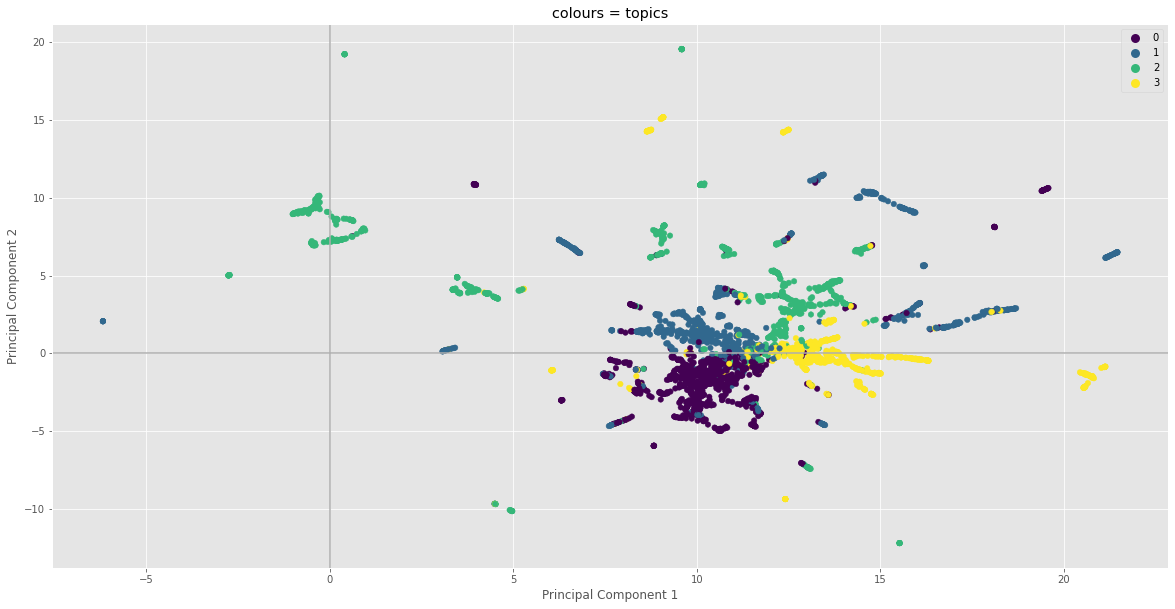

In [ ]:
umap_emb = umap.UMAP()
# X_2D_umap = umap_emb.fit_transform(X.todense())
X_2D_umap = umap_emb.fit_transform(X_50_SVD)


# рисуем сабплоты
fig, plot1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 10))

# цвета = темы
draw_subplots(X_2D_umap, labels, plot1, n_clusters, header='colours = topics')

In [ ]:
umap_emb = umap.UMAP()
X_2D_umap = umap_emb.fit_transform(X.todense())
# X_2D_umap = umap_emb.fit_transform(X_50_SVD)


# рисуем сабплоты
fig, plot1 = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(20, 10))

# цвета = темы
draw_subplots(X_2D_umap, labels, plot1, n_clusters, header='colours = topics')

## Задание
#### 1
Проделайте все то же самое с другим набором тем или на каком-нибудь вашем датасете.  
Хорошо ли отделяются друг от друга близкие темы (например, 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space')?  
Соответствует ли количество тем количеству кластеров, или же кластеров на глаз больше/меньше?

#### 2
Задайте побольше классов (например, 20) в KMeans, а потом преобразуйте данные с помощью t-SNE и раскрасьте точки на графике в соответствии с полученными из KMeans кластерами.  
Насколько результаты кластеризации совпадают с проекцией t-SNE?

#### 3
Возьмите датасет русских новостей, e.g. той же Ленты, что и на всех занятиях, сделайте снижение размерности и посмотрите, сочетается ли оно с оригинальными классами.